In [1]:
__imp

Libraries have been loaded


## Load Additional Libraries

In [2]:
basepath = os.path.expanduser('../')

## Load Data

In [10]:
%%time

app_train = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/application_train.pkl'))
# app_test  = pd.read_feather(os.path.join(basepath, 'data/processed/application_test.feather'))

# bureau       = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/bureau.pkl'))
prev_app     = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/previous_application.pkl'))
# installments = pd.read_pickle(os.path.join(basepath, 'data/processed/installments_payments.pkl')) 
# pos_cash     = pd.read_pickle(os.path.join(basepath, 'data/processed/pos_cash.pkl'))
# credit_bal  = pd.read_pickle(os.path.join(basepath, 'data/processed/credit_card_balance.pkl'))

CPU times: user 46.9 ms, sys: 217 ms, total: 264 ms
Wall time: 2.19 s


In [4]:
app_train.sample(n=10).SK_ID_CURR

14981     117491
168780    295636
58653     167989
36682     142486
69900     181082
109580    227086
127783    248201
141197    263704
217823    352370
299252    446680
Name: SK_ID_CURR, dtype: int32

In [5]:
bureau.loc[bureau.SK_ID_CURR == 227086]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
1013064,227086,5130136,Closed,currency 1,-1204,0,-947.0,-947.0,NaN,0,0.000000,0.0,0.0,0.0,Credit card,-465,NaN
1013065,227086,5130137,Closed,currency 1,-656,0,-352.0,-352.0,NaN,0,105205.500000,0.0,0.0,0.0,Consumer credit,-341,NaN
1013066,227086,5130139,Active,currency 1,-386,0,527.0,NaN,NaN,0,676800.000000,458689.5,0.0,0.0,Consumer credit,-18,NaN
1013067,227086,5130140,Closed,currency 1,-1448,0,-1083.0,-1083.0,7190.910156,0,33421.500000,0.0,0.0,0.0,Consumer credit,-1082,NaN
1013068,227086,5130141,Closed,currency 1,-1432,0,-793.0,-793.0,2193.479980,0,60642.539062,0.0,0.0,0.0,Consumer credit,-793,NaN
1351919,227086,5130138,Closed,currency 1,-1433,0,-793.0,-793.0,NaN,0,60642.000000,0.0,0.0,0.0,Consumer credit,-667,NaN


In [40]:
bureau.CREDIT_ACTIVE.cat.codes.value_counts()

2    1079273
0     630607
3       6527
1         21
dtype: int64

In [41]:
bureau.CREDIT_ACTIVE.value_counts()

Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64

In [30]:
# find all active records and take mean of days credit
res = bureau.loc[bureau.CREDIT_ACTIVE == 'Active', ['SK_ID_CURR', 'DAYS_CREDIT']]
res = -res.groupby('SK_ID_CURR')['DAYS_CREDIT'].mean()

res = app_train.SK_ID_CURR.map(res)

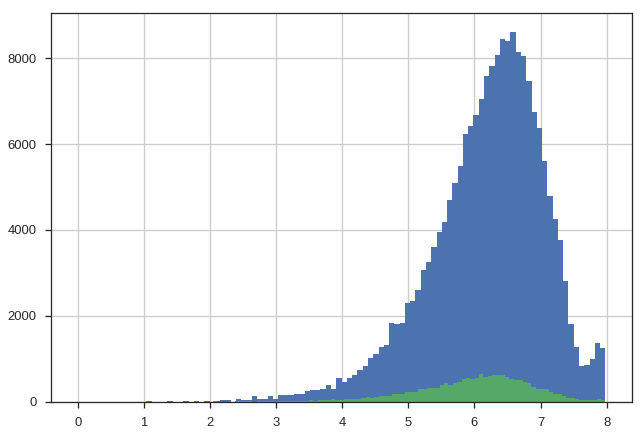

In [31]:
res[(app_train.TARGET == 0)].map(np.log1p).hist(bins=100)
res[(app_train.TARGET == 1)].map(np.log1p).hist(bins=100);

In [35]:
# find all active records and take mean of days credit
res = bureau.loc[bureau.CREDIT_ACTIVE == 'Active', ['SK_ID_CURR', 'AMT_CREDIT_SUM']]
res = res.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum()

res = app_train.SK_ID_CURR.map(res)

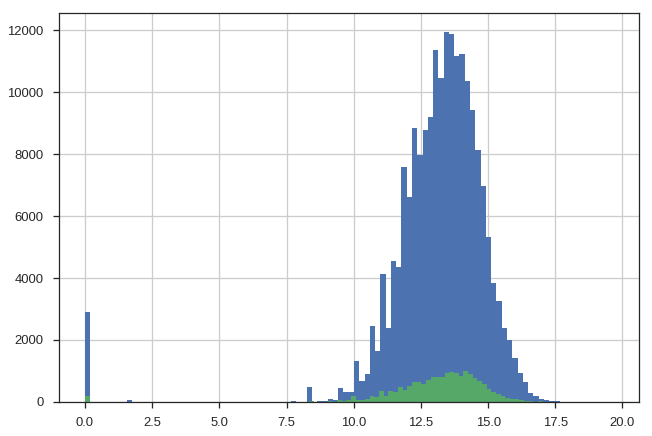

In [37]:
res[(app_train.TARGET == 0)].map(np.log1p).hist(bins=100)
res[(app_train.TARGET == 1)].map(np.log1p).hist(bins=100);

In [38]:
res[(app_train.TARGET == 0)].map(np.log1p).mean(), res[(app_train.TARGET == 1)].map(np.log1p).mean()

(13.120186969465449, 13.145019527952881)

In [17]:
# when was last update about active credit reached bureau ?
res = bureau.loc[bureau.CREDIT_ACTIVE == 'Active', ['SK_ID_CURR', 'DAYS_CREDIT_UPDATE']]
res = -res.groupby('SK_ID_CURR')['DAYS_CREDIT_UPDATE'].max()

res = app_train.SK_ID_CURR.map(res)

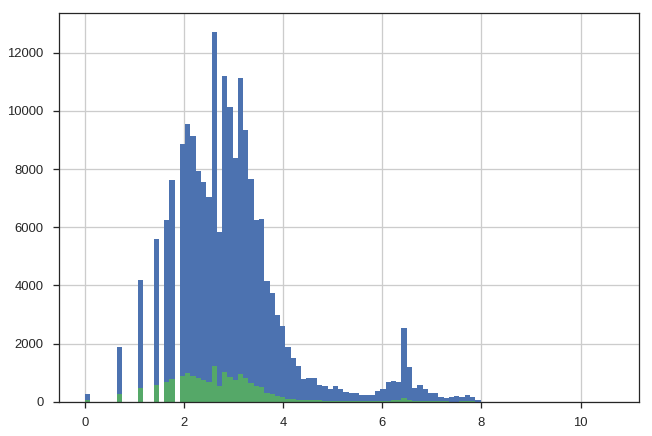

In [18]:
res[(app_train.TARGET == 0)].map(np.log1p).hist(bins=100)
res[(app_train.TARGET == 1)].map(np.log1p).hist(bins=100);

In [29]:
# how many active loans since last two years
res = bureau.loc[(bureau.CREDIT_ACTIVE == 'Active') & (bureau.DAYS_CREDIT > -365*1), ['SK_ID_CURR', 'DAYS_CREDIT_UPDATE']]
res = res.groupby('SK_ID_CURR').size()

res = app_train.SK_ID_CURR.map(res)

In [30]:
ss = pd.crosstab(res, app_train.TARGET)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
ss

TARGET,0.0,1.0,ratio
SK_ID_CURR,,,
1.0,77298,6724,0.080027
2.0,32324,3686,0.102360
3.0,10721,1556,0.126741
4.0,3302,670,0.168681
5.0,1003,263,0.207741
6.0,298,104,0.258706
7.0,88,39,0.307087
8.0,32,11,0.255814
9.0,8,2,0.200000


In [40]:
# total amount credit courtesy of recent loans
res = bureau.loc[(bureau.CREDIT_ACTIVE == 'Active') & (bureau.DAYS_CREDIT > -365*2), ['SK_ID_CURR', 'AMT_CREDIT_SUM']]
res = res.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum()

res = app_train.SK_ID_CURR.map(res)
res = app_train.AMT_INCOME_TOTAL - (res + app_train.AMT_CREDIT)

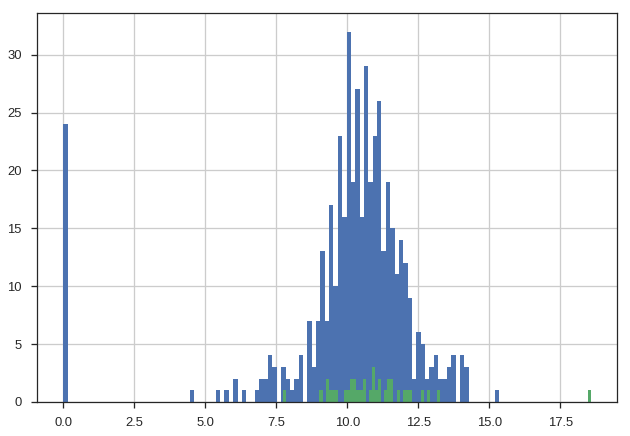

In [41]:
res[(app_train.TARGET == 0)].map(np.log1p).hist(bins=100)
res[(app_train.TARGET == 1)].map(np.log1p).hist(bins=100);

In [27]:
res = bureau.loc[(bureau.CREDIT_ACTIVE == 'Active') & (bureau.DAYS_CREDIT > -365*2), :]
res = res.groupby(['SK_ID_CURR'])['CREDIT_TYPE'].nunique()

res = app_train.SK_ID_CURR.map(res).fillna(-1)

ss = pd.crosstab(res, app_train.TARGET)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
ss

TARGET,0.0,1.0,ratio
SK_ID_CURR,,,
-1.0,116234,8859,0.070819
1.0,106815,8799,0.076107
2.0,57000,6715,0.105391
3.0,2599,436,0.143657
4.0,38,16,0.296296


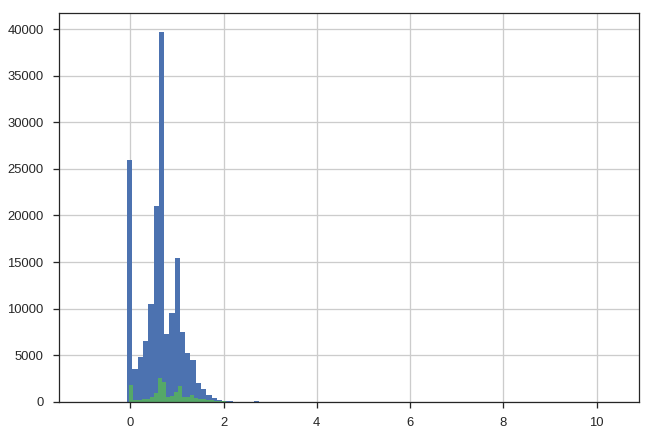

In [20]:
res[app_train.TARGET == 0].map(np.log1p).hist(bins=100)
res[app_train.TARGET == 1].map(np.log1p).hist(bins=100);

In [29]:
ss = pd.crosstab(app_train.ORGANIZATION_TYPE, app_train.TARGET)
ss.loc[:, 'ratio'] = ss[1] / (ss[0] + ss[1])
ss

TARGET,0.0,1.0,ratio
ORGANIZATION_TYPE,,,
Advertising,394,35,0.081585
Agriculture,2197,257,0.104727
Bank,2377,130,0.051855
Business Entity Type 1,5497,487,0.081384
Business Entity Type 2,9653,900,0.085284
Business Entity Type 3,61669,6323,0.092996
Cleaning,231,29,0.111538
Construction,5936,785,0.116798
Culture,358,21,0.055409


In [ ]:
../data/interim/dataset1/previo

In [9]:
prev_app

,most_recent_prev_application,max_prev_annuity_goods,max_prev_annuity_credit,num_diff_reasons_rejections,dev_weekday_process,credit_duration_prev,dev_hour_process,past_annuity_to_credit_mean,ratio_annuity_credit_running_loans,most_freq_rejection_reason,...,down_payment_to_application,mean_down_payment_rate,diff_termination_decision,mean_hour_process,diff_prev_curr_annuity,running_loans,past_annuity_to_credit_std,diff_dp_annuity,mean_prev_annuity_goods,ratio_prev_curr_annuity
0,-606.0,0.051670,0.051670,1,NaN,589.000000,NaN,0.051670,NaN,7.0,...,0.000000,0.000000,589.000000,9.000000,-24691.367188,0.0,NaN,-9251.775391,0.051670,0.000370
1,-746.0,0.191312,0.185200,1,1.527525,257.666656,2.516612,0.126383,NaN,7.0,...,0.100059,0.050018,257.666656,14.666667,-35687.558594,0.0,0.050977,-70616.218750,0.132837,0.000307
2,-815.0,0.220626,0.266450,1,NaN,101.000000,NaN,0.266450,NaN,7.0,...,0.200148,0.212036,101.000000,5.000000,-6741.413574,0.0,NaN,-4326.754395,0.220626,0.001272
3,-181.0,0.092260,0.108340,2,0.833333,119.500000,1.000000,0.069304,0.059800,7.0,...,0.300089,0.163330,119.500000,14.666667,-29676.429688,7.0,0.032882,-16628.851562,0.066708,0.000339
4,-374.0,0.116160,0.125499,1,1.471960,393.000000,2.503331,0.090659,0.051994,7.0,...,0.314188,0.159546,393.000000,12.333333,-21856.083984,2.0,0.032229,-4320.144531,0.091548,0.000431
5,-82.0,0.180385,0.200701,1,1.516575,596.750000,3.674235,0.118055,NaN,7.0,...,0.201225,0.073059,596.750000,12.000000,-27507.830078,1.0,0.061962,-36230.695312,0.111655,0.000351
6,-74.0,0.188181,0.197370,1,1.976047,238.000000,2.984085,0.155250,0.117550,7.0,...,0.850043,0.126587,238.000000,13.714286,-41291.785156,1.0,0.046181,-59613.394531,0.141280,0.000223
7,-1070.0,0.111093,0.105300,1,NaN,308.000000,NaN,0.105300,NaN,7.0,...,0.000000,0.000000,308.000000,16.000000,-42064.781250,0.0,NaN,-27463.410156,0.111093,0.000243
8,-1162.0,0.107512,0.108700,2,2.217356,1114.000000,3.593976,0.067133,0.050000,7.0,...,0.100010,0.050018,1114.000000,11.750000,-33816.683594,2.0,0.036182,-44549.636719,0.076938,0.000290
9,-107.0,0.160901,0.127108,1,2.380476,444.666656,2.516612,0.093557,NaN,7.0,...,0.000000,0.000000,444.666656,12.500000,-20241.025391,1.0,0.029710,-3012.074951,0.116378,0.000443


In [11]:
prev_app.loc[:, ['SK_ID_CURR', 'NAME_CONTRACT_STATUS']]

,SK_ID_CURR,NAME_CONTRACT_STATUS
0,271877,Approved
1,108129,Approved
2,122040,Approved
3,176158,Approved
4,202054,Refused
5,199383,Approved
6,175704,Canceled
7,296299,Canceled
8,342292,Canceled
9,334349,Canceled
